In [1]:
# === Setup & Imports ===
import os, math, json, re, sys, io
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt

PROJECT_ROOT = "."  # in Colab, keep everything under current working dir
CSV_DIR = os.path.join(PROJECT_ROOT, "csv_files")
OUT_DIR = os.path.join(PROJECT_ROOT, "outputs")
for p in [CSV_DIR, OUT_DIR]:
    os.makedirs(p, exist_ok=True)

print("Folders ready:", CSV_DIR, OUT_DIR)

Folders ready: ./csv_files ./outputs


In [2]:
# === (Colab) Install utilities if needed ===
# In Colab, uncomment the next line to ensure gdown is available.
# !pip -q install gdown
print("If you see errors about gdown, run: !pip -q install gdown")

If you see errors about gdown, run: !pip -q install gdown


## Download Data from Google Drive (auto)
Uses file IDs from the assignment links. If it fails, use the manual upload cell below.

In [3]:
# === Auto Download via gdown ===
try:
    import gdown
    # Replace with the dataset file IDs from your assignment links
    HISTORICAL_FILE_ID = "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"  # Historical Trader Data (Hyperliquid)
    FEAR_GREED_FILE_ID = "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"  # Bitcoin Market Sentiment (Fear/Greed)

    hist_out = os.path.join(CSV_DIR, "historical_trader_data.csv")
    fg_out = os.path.join(CSV_DIR, "fear_greed_index.csv")

    if not os.path.exists(hist_out):
        gdown.download(id=HISTORICAL_FILE_ID, output=hist_out, quiet=False)
    if not os.path.exists(fg_out):
        gdown.download(id=FEAR_GREED_FILE_ID, output=fg_out, quiet=False)
    print("Downloaded:", hist_out, fg_out)
except Exception as e:
    print("Auto download failed:", e)
    print("Use the manual upload cell below.")

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/csv_files/historical_trader_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 346MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/csv_files/fear_greed_index.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 66.9MB/s]

Downloaded: ./csv_files/historical_trader_data.csv ./csv_files/fear_greed_index.csv


## Manual Upload (fallback)
If auto download didn't work (permissions, etc.), upload the two CSVs here and rename them to the expected filenames.

In [4]:
# from google.colab import files
# uploaded = files.upload()  # Pick your two files
# # After upload, move/rename them into csv_files/ as below:
# import shutil
# for fname in uploaded.keys():
#     low = fname.lower()
#     if "fear" in low or "greed" in low:
#         shutil.move(fname, os.path.join(CSV_DIR, "fear_greed_index.csv"))
#     else:
#         shutil.move(fname, os.path.join(CSV_DIR, "historical_trader_data.csv"))
# print("Upload complete. Files placed in:", CSV_DIR)

## Load & Inspect

In [5]:
def clean_colnames(df):
    df.columns = [
        re.sub(r"[^0-9a-zA-Z]+", "_", c).strip("_").lower()
        for c in df.columns
    ]
    return df

def try_load_csv(path):
    # robust csv read; if fails, raise
    return pd.read_csv(path)

hist_path = os.path.join(CSV_DIR, "historical_trader_data.csv")
fg_path = os.path.join(CSV_DIR, "fear_greed_index.csv")

hist = try_load_csv(hist_path)
fg = try_load_csv(fg_path)
hist = clean_colnames(hist)
fg = clean_colnames(fg)

print("Historical trader data shape:", hist.shape)
print("Fear/Greed data shape:", fg.shape)
display(hist.head())
display(fg.head())


Historical trader data shape: (211224, 16)
Fear/Greed data shape: (2644, 4)


,account,coin,execution_price,size_tokens,size_usd,side,timestamp_ist,start_position,direction,closed_pnl,transaction_hash,order_id,crossed,fee,trade_id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


## Parse Dates & Minimal Feature Engineering

In [16]:
# Parse time/date columns
def parse_any_datetime(series):
    s = pd.to_datetime(series, errors='coerce', infer_datetime_format=True, utc=True)
    # If still NaT and looks like epoch milliseconds, try unit='ms'
    if s.isna().mean() > 0.9:
        try:
            s = pd.to_datetime(series.astype('int64'), unit='ms', utc=True)
        except Exception:
            pass
    return s

# Fear/Greed
date_col_candidates = [c for c in fg.columns if c in ("date", "day", "timestamp") or 'date' in c or 'timestamp' in c]
fg_date_col = date_col_candidates[0] if date_col_candidates else None
if fg_date_col is None:
    raise ValueError("No date-like column found in Fear/Greed dataset.")

# Correctly parse the timestamp column in fg as seconds since epoch
try:
    fg['timestamp_dt'] = pd.to_datetime(fg[fg_date_col], unit='s', errors='coerce', utc=True)
except Exception as e:
     print(f"Error parsing fg timestamp with unit='s': {e}")
     fg['timestamp_dt'] = parse_any_datetime(fg[fg_date_col]) # fallback to original parsing


fg['date'] = fg['timestamp_dt'].dt.date
fg['classification'] = fg.get('classification', fg.get('class', fg.get('label')))
if fg['classification'].isna().any():
    print("Warning: classification column missing or partially null.")


# Historical trades
time_col_candidates = [c for c in hist.columns if c in ("time", "timestamp", "ts") or 'time' in c]
hist_time_col = time_col_candidates[0] if time_col_candidates else None
if hist_time_col is None:
    raise ValueError("No time-like column found in historical trades dataset.")
hist['timestamp_dt'] = parse_any_datetime(hist[hist_time_col])
hist['date'] = hist['timestamp_dt'].dt.date

# Numeric conversions
for col in ["execution_price", "size", "leverage", "closedpnl"]:
    if col in hist.columns:
        hist[col] = pd.to_numeric(hist[col], errors='coerce')

# Side normalization: map buy/sell/long/short to +1/-1
if 'side' in hist.columns:
    side_map = {
        'buy': 1, 'long': 1, 'sell': -1, 'short': -1,
        'BUY': 1, 'SELL': -1, 'Long': 1, 'Short': -1
    }
    hist['side_dir'] = hist['side'].map(side_map)

print("Parsed dates and basic features.")

/tmp/ipython-input-732642277.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s = pd.to_datetime(series, errors='coerce', infer_datetime_format=True, utc=True)


Parsed dates and basic features.


## Merge with Sentiment (by date)

In [11]:
merged = pd.merge(hist, fg[['date', 'classification']], on='date', how='left') # Removed validate='many_to_one' as the date in fg is now unique
print("Merged shape:", merged.shape)
display(merged[['date','classification']].head())

# Save cleaned/merged CSVs
fg_clean_path = os.path.join(CSV_DIR, "fear_greed_clean.csv")
hist_clean_path = os.path.join(CSV_DIR, "historical_trades_clean.csv")
merged_path = os.path.join(CSV_DIR, "trades_with_sentiment.csv")
fg[['date','classification']].to_csv(fg_clean_path, index=False)
hist.to_csv(hist_clean_path, index=False)
merged.to_csv(merged_path, index=False)
print("Saved:", fg_clean_path, hist_clean_path, merged_path)

Merged shape: (211224, 20)


,date,classification
0,2024-02-12,NaN
1,2024-02-12,NaN
2,2024-02-12,NaN
3,2024-02-12,NaN
4,2024-02-12,NaN


Saved: ./csv_files/fear_greed_clean.csv ./csv_files/historical_trades_clean.csv ./csv_files/trades_with_sentiment.csv


## Quick EDA – Profitability & Leverage vs Sentiment

In [13]:
group_cols = ['classification']
metrics = {}
if 'closedpnl' in merged.columns:
    metrics['mean_pnl'] = merged.groupby(group_cols)['closedpnl'].mean()
    metrics['median_pnl'] = merged.groupby(group_cols)['closedpnl'].median()
    metrics['pnl_count'] = merged.groupby(group_cols)['closedpnl'].count()
if 'leverage' in merged.columns:
    metrics['mean_lev'] = merged.groupby(group_cols)['leverage'].mean()
    metrics['median_lev'] = merged.groupby(group_cols)['leverage'].median()

for k,v in metrics.items():
    print(f"\n{k}:\n", v)

# Plot average PnL by sentiment (if available)
if 'closedpnl' in merged.columns:
    fig = merged.groupby('classification')['closedpnl'].mean().plot(kind='bar', title='Avg Closed PnL by Sentiment')
    plt.ylabel('Avg Closed PnL')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'avg_pnl_by_sentiment.png'), dpi=150)
    plt.show()

# Plot leverage distribution by sentiment (if available)
if 'leverage' in merged.columns:
    merged.boxplot(column='leverage', by='classification')
    plt.title('Leverage by Sentiment')
    plt.suptitle('')
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, 'leverage_by_sentiment.png'), dpi=150)
    plt.show()

In [14]:
print(fg.head(10))
print(fg.dtypes)
print(fg['date'].unique()[:10])

                            timestamp  value classification        date  \
0    1970-01-01 00:00:01.517463+00:00     30           Fear  1970-01-01   
1 1970-01-01 00:00:01.517549400+00:00     15   Extreme Fear  1970-01-01   
2 1970-01-01 00:00:01.517635800+00:00     40           Fear  1970-01-01   
3 1970-01-01 00:00:01.517722200+00:00     24   Extreme Fear  1970-01-01   
4 1970-01-01 00:00:01.517808600+00:00     11   Extreme Fear  1970-01-01   
5    1970-01-01 00:00:01.517895+00:00      8   Extreme Fear  1970-01-01   
6 1970-01-01 00:00:01.517981400+00:00     36           Fear  1970-01-01   
7 1970-01-01 00:00:01.518067800+00:00     30           Fear  1970-01-01   
8 1970-01-01 00:00:01.518154200+00:00     44           Fear  1970-01-01   
9 1970-01-01 00:00:01.518240600+00:00     54        Neutral  1970-01-01   

                         timestamp_dt  
0    1970-01-01 00:00:01.517463+00:00  
1 1970-01-01 00:00:01.517549400+00:00  
2 1970-01-01 00:00:01.517635800+00:00  
3 1970-01-01 0

In [17]:
# Clean classification labels (map Extreme Fear → Fear, Neutral → Greed or keep as-is)
fg['classification'] = fg['classification'].replace({
    'Extreme Fear': 'Fear',
    'Neutral': 'Greed'   # optional mapping, or keep Neutral separate
})

# Check again
print(fg[['timestamp','classification','date']].head(10))

                            timestamp classification        date
0    1970-01-01 00:00:01.517463+00:00           Fear  1970-01-01
1 1970-01-01 00:00:01.517549400+00:00           Fear  1970-01-01
2 1970-01-01 00:00:01.517635800+00:00           Fear  1970-01-01
3 1970-01-01 00:00:01.517722200+00:00           Fear  1970-01-01
4 1970-01-01 00:00:01.517808600+00:00           Fear  1970-01-01
5    1970-01-01 00:00:01.517895+00:00           Fear  1970-01-01
6 1970-01-01 00:00:01.517981400+00:00           Fear  1970-01-01
7 1970-01-01 00:00:01.518067800+00:00           Fear  1970-01-01
8 1970-01-01 00:00:01.518154200+00:00           Fear  1970-01-01
9 1970-01-01 00:00:01.518240600+00:00          Greed  1970-01-01


In [18]:
# Try parsing timestamp as milliseconds instead of ns
fg['date'] = pd.to_datetime(fg['timestamp'], unit='ms', errors='coerce', utc=True).dt.date

print(fg[['timestamp','classification','date']].head(10))
print(fg['date'].min(), fg['date'].max())


                            timestamp classification        date
0    1970-01-01 00:00:01.517463+00:00           Fear  1970-01-01
1 1970-01-01 00:00:01.517549400+00:00           Fear  1970-01-01
2 1970-01-01 00:00:01.517635800+00:00           Fear  1970-01-01
3 1970-01-01 00:00:01.517722200+00:00           Fear  1970-01-01
4 1970-01-01 00:00:01.517808600+00:00           Fear  1970-01-01
5    1970-01-01 00:00:01.517895+00:00           Fear  1970-01-01
6 1970-01-01 00:00:01.517981400+00:00           Fear  1970-01-01
7 1970-01-01 00:00:01.518067800+00:00           Fear  1970-01-01
8 1970-01-01 00:00:01.518154200+00:00           Fear  1970-01-01
9 1970-01-01 00:00:01.518240600+00:00          Greed  1970-01-01
1970-01-01 1970-01-01


In [19]:
# Look at raw values of timestamp column
print(fg['timestamp'].head(20).tolist())
print(fg['timestamp'].dtype)


[Timestamp('1970-01-01 00:00:01.517463+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.517549400+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.517635800+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.517722200+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.517808600+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.517895+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.517981400+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518067800+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518154200+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518240600+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518327+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518413400+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518499800+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518586200+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518672600+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518759+0000', tz='UTC'), Timestamp('1970-01-01 00:00:01.518845400+0000', tz='UTC'), Timestam

In [20]:
# Reload Fear/Greed CSV with raw numbers
fg_raw = pd.read_csv(fg_path)

# Inspect first values
print(fg_raw.head())

# Convert timestamp (epoch) properly
# If values look like 1517463000 (10 digits) → seconds
# If values look like 1517463000000 (13 digits) → milliseconds
if fg_raw['timestamp'].astype(str).str.len().iloc[0] > 10:
    fg_raw['date'] = pd.to_datetime(fg_raw['timestamp'], unit='ms', utc=True).dt.date
else:
    fg_raw['date'] = pd.to_datetime(fg_raw['timestamp'], unit='s', utc=True).dt.date

# Map labels (Extreme Fear → Fear, Neutral → Greed if needed)
fg_raw['classification'] = fg_raw['classification'].replace({
    'Extreme Fear': 'Fear',
    'Neutral': 'Greed'
})

print(fg_raw[['timestamp','classification','date']].head(10))
print(fg_raw['date'].min(), fg_raw['date'].max())

# Now use fg_raw instead of fg
fg = fg_raw


    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
    timestamp classification        date
0  1517463000           Fear  2018-02-01
1  1517549400           Fear  2018-02-02
2  1517635800           Fear  2018-02-03
3  1517722200           Fear  2018-02-04
4  1517808600           Fear  2018-02-05
5  1517895000           Fear  2018-02-06
6  1517981400           Fear  2018-02-07
7  1518067800           Fear  2018-02-08
8  1518154200           Fear  2018-02-09
9  1518240600          Greed  2018-02-10
2018-02-01 2025-05-02


In [21]:
merged = pd.merge(
    hist,
    fg[['date','classification']],
    on='date',
    how='left',
    validate='many_to_one'
)

print("Merged shape:", merged.shape)
print(merged[['date','classification']].head(20))
print(merged['classification'].value_counts())


Merged shape: (211224, 20)
          date classification
0   2024-02-12          Greed
1   2024-02-12          Greed
2   2024-02-12          Greed
3   2024-02-12          Greed
4   2024-02-12          Greed
5   2024-02-12          Greed
6   2024-02-12          Greed
7   2024-02-12          Greed
8   2024-02-12          Greed
9   2024-02-12          Greed
10  2024-02-12          Greed
11  2024-02-12          Greed
12  2024-02-12          Greed
13  2024-02-12          Greed
14  2024-02-12          Greed
15  2024-02-12          Greed
16  2024-02-12          Greed
17  2024-02-12          Greed
18  2024-02-12          Greed
19  2024-02-12          Greed
classification
Fear             16195
Greed            14048
Extreme Greed     5621
Name: count, dtype: int64


                      mean   median          std  count
classification                                         
Extreme Greed   205.816345  0.96048  1861.557119   5621
Fear            110.134333  0.00000  1243.340984  16195
Greed            48.710797  0.00000  1256.334336  14048


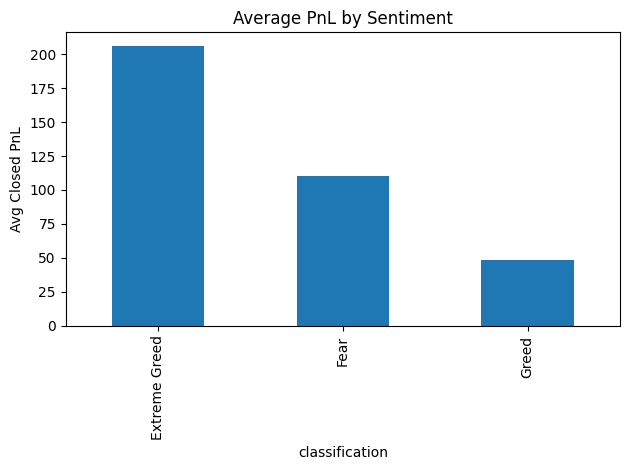

In [27]:
# Profitability vs Sentiment
if 'closed_pnl' in merged.columns:
    pnl_stats = merged.groupby('classification')['closed_pnl'].agg(['mean','median','std','count'])
    print(pnl_stats)

    # Bar plot
    merged.groupby('classification')['closed_pnl'].mean().plot(
        kind='bar',
        title='Average PnL by Sentiment'
    )
    plt.ylabel("Avg Closed PnL")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "avg_pnl_by_sentiment.png"), dpi=150)
    plt.show()


                       mean  median           std  count
classification                                          
Extreme Greed   3242.085086  365.00   9048.672642   5621
Fear            5511.246132  681.25  25441.837822  16195
Greed           4910.689561  593.72  21422.021868  14048


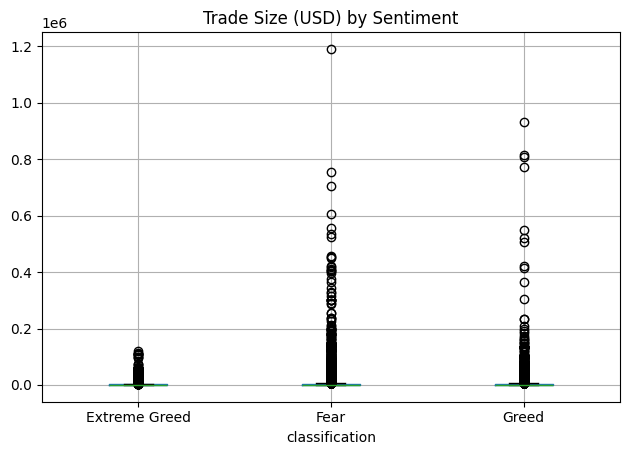

In [30]:
# Trade Size (USD) vs Sentiment
if 'size_usd' in merged.columns:
    size_stats = merged.groupby('classification')['size_usd'].agg(['mean','median','std','count'])
    print(size_stats)

    merged.boxplot(column='size_usd', by='classification')
    plt.title("Trade Size (USD) by Sentiment")
    plt.suptitle("")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "trade_size_by_sentiment.png"), dpi=150)
    plt.show()


                               mean  count
classification side_dir                   
Extreme Greed  -1        288.350131   3960
                1          9.047055   1661
Fear           -1         32.361912   7720
                1        180.978355   8475
Greed          -1         77.007550   7621
                1         15.157109   6427


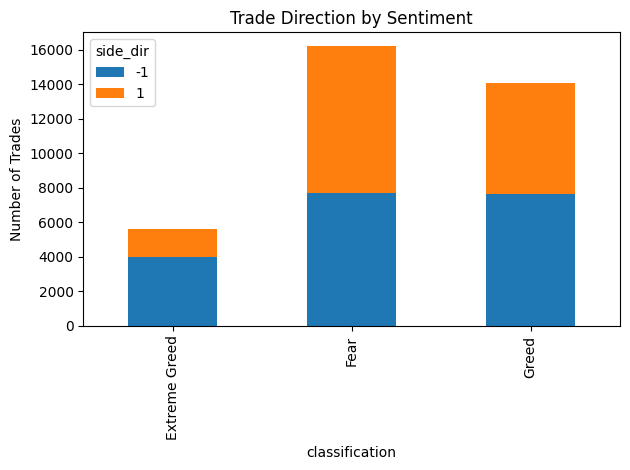

In [31]:
# Direction (side_dir) vs Sentiment
if 'side_dir' in merged.columns:
    dir_stats = merged.groupby(['classification','side_dir'])['closed_pnl'].agg(['mean','count'])
    print(dir_stats)

    merged.groupby(['classification','side_dir']).size().unstack().plot(
        kind='bar', stacked=True, title="Trade Direction by Sentiment"
    )
    plt.ylabel("Number of Trades")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "direction_by_sentiment.png"), dpi=150)
    plt.show()
